# Housekeeping

## Library imports

In [10]:
from click.formatting import iter_rows

if False:
    import sys
    !{sys.executable} -m pip install -r requirements.txt

## This block did not effectively install modules from requirements file - done manually using "pip install -r notebooks/requirements.txt"

In [55]:
# TODO: remove unnecessary packages
import pandas as pd
import numpy as np

import sklearn
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from scipy import stats


from sklearn.model_selection import (
    GridSearchCV,
    RepeatedStratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from colorama import Fore, Back, Style

import warnings

import matplotlib.pyplot as plt

import seaborn as sns

## Settings

In [12]:
warnings.filterwarnings("ignore")
sklearn.set_config(transform_output="pandas")
print(Style.RESET_ALL)

## Data imports
Data was manually edited, to convert the mpa411.txt TSV format to a CSV format. Otherwise, Pandas was loading it as a single column, somehow. The first row, containing only "#mpa_vJun23_CHOCOPhlAnSGB_202403" was removed.

In [13]:
data = pd.read_csv('../data/raw/MAI3004_lucki_mpa411.csv')
metadata = pd.read_csv('../data/raw/MAI3004_lucki_metadata_safe.csv')
print(
    f"Data successfully imported. \n shape of data: {data.shape} \n "
    f"Shape of metadata: {metadata.shape}"
)

assert data.shape == (6903, 932), "Data has the wrong shape. Check the CSV formatting."
assert metadata.shape == (930, 6), "Metadata has the wrong shape. Check the CSV formatting."


Data successfully imported. 
 shape of data: (6903, 932) 
 Shape of metadata: (930, 6)


## Function definitions
| Function Name | Description | Parameters |
|---------------|-------------|------------|


# Data preprocessing

## Merge data and metadata

In [14]:
sample_cols = [col for col in data.columns if col.startswith("mpa411_")]

sample_abundances = (
    data[['clade_name'] + sample_cols]
    .set_index('clade_name')
    .transpose()
    .rename_axis('original_sample_id')
    .reset_index()
    .rename(columns={'original_sample_id': 'sample_id'})
)

sample_abundances["sample_id"] = (
    sample_abundances["sample_id"].str.removeprefix(
        "mpa411_",
    )
)

metadata_common = metadata[
    metadata["sample_id"].isin(sample_abundances["sample_id"])
].copy()
merged_samples = metadata_common.merge(
    sample_abundances,
    on="sample_id",
    how="inner",
)

merged_samples.drop(columns=['year_of_birth', 'body_product'], inplace=True)
# YOB and body_product are omitted without sample dates.
# All samples are fecal.
# TODO: should we be accounting for sex? Do statistical analysis

print(f"Metadata rows (original): {metadata.shape[0]}")
print(f"Metadata rows with matching samples: {metadata_common.shape[0]}")
print(
    f"Metadata rows without matching samples: "
    f"{metadata_common.shape[0]-metadata_common.shape[0]}"
)
print(f"Merged dataframe shape: {merged_samples.shape}")

Metadata rows (original): 930
Metadata rows with matching samples: 930
Metadata rows without matching samples: 0
Merged dataframe shape: (930, 6907)


In [15]:
merged_samples.head()

,sample_id,family_id,sex,age_group_at_sample,UNCLASSIFIED,k__Bacteria,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Candidatus_Saccharibacteria,...,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03|t__SGB4260,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033|t__SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061|t__SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528|t__SGB6528
0,MMHP_Lucki_0001,ENA_fam_0139,female,1-2 weeks,11.15024,88.849765,51.309655,0.002106,34.721253,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MMHP_Lucki_0002,ENA_fam_0139,female,NaN,13.65529,86.284502,4.551376,0.041143,71.819009,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MMHP_Lucki_0003,ENA_fam_0136,female,1-2 weeks,20.33656,79.663440,64.794124,10.664824,0.526129,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MMHP_Lucki_0004,ENA_fam_0136,female,NaN,11.30536,88.694643,11.944587,0.284914,73.876500,0.00259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MMHP_Lucki_0005,ENA_fam_0136,female,4 weeks,21.67587,78.324133,57.245464,18.558613,0.918946,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Encoding

In [16]:
# Sex and family_ID
encoded_samples = merged_samples.copy().dropna(subset="age_group_at_sample")

encoded_samples["sex"] = (
    encoded_samples["sex"]
    .fillna("unknown")
    .replace({"female": 1, "male": 0, "unknown": 2})
)
encoded_samples["family_id"] = LabelEncoder().fit_transform(
    encoded_samples["family_id"]
)


In [17]:
encoding_guide = {
    '1-2 weeks': 1,
    '4 weeks': 2,
    '8 weeks': 3,
    '4 months': 4,
    '5 months': 5,
    '6 months': 6,
    '9 months': 7,
    '11 months': 8,
    '14 months': 9,
}
encoded_samples["age_group_at_sample"].replace(encoding_guide, inplace=True)

In [18]:
if False in pd.DataFrame(encoded_samples["age_group_at_sample"]).applymap(np.isreal): #fallback encoder
    age_encoder = LabelEncoder().fit(encoded_samples["age_group_at_sample"])
    encoded_samples["age_group_at_sample"] = age_encoder.transform(
        encoded_samples["age_group_at_sample"]
    )

    age_groups = dict(
        zip(age_encoder.classes_, age_encoder.transform(age_encoder.classes_))
    )
    print("Age group encoding:", age_groups)

else:
    print("Fallback encoding not needed")

Fallback encoding not needed


## Missing check

In [19]:
missing_table = (
    encoded_samples.isna()
    .sum()
    .to_frame(name="missing_count")
    .assign(
        missing_percent=lambda df: (
            (df["missing_count"] / encoded_samples.shape[0] * 100).round(2)
        ),
    )
    .reset_index()
    .rename(columns={"index": "column"})
    .sort_values("missing_count", ascending=False)
    .query("missing_count != 0")
)

if len(missing_table) > 0:
    missing_table
else:
    print("No missing values detected.")

No missing values detected.


## Outlier check

In [20]:
numeric_cols = encoded_samples.select_dtypes(include=[np.number]).columns

q1 = encoded_samples[numeric_cols].quantile(0.25)
q3 = encoded_samples[numeric_cols].quantile(0.75)
iqr = q3 - q1

lower_bounds = q1 - 1.5 * iqr
upper_bounds = q3 + 1.5 * iqr

outlier_mask = (
    (encoded_samples[numeric_cols] < lower_bounds)
    | (encoded_samples[numeric_cols] > upper_bounds)
)
outlier_counts = outlier_mask.sum()
outlier_percent = (outlier_counts / encoded_samples.shape[0] * 100).round(2)

outlier_table = (
    pd.DataFrame({
        "column": numeric_cols,
        "lower_bound": lower_bounds,
        "upper_bound": upper_bounds,
        "outlier_count": outlier_counts,
        "outlier_percent": outlier_percent,
    })
    .query("outlier_count > 0")
    .sort_values("outlier_percent", ascending=False)
    .reset_index(drop=True)
)

outlier_table

,column,lower_bound,upper_bound,outlier_count,outlier_percent
0,k__Bacteria|p__Actinobacteria|c__Actinomycetia...,0.000000,0.000000,201,24.88
1,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,0.000000,0.000000,201,24.88
2,k__Bacteria|p__Verrucomicrobia,-0.000195,0.000325,200,24.75
3,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,0.000000,0.000000,198,24.50
4,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacill...,0.000000,0.000000,198,24.50
...,...,...,...,...,...
5155,k__Bacteria|p__Firmicutes|c__CFGB1765|o__OFGB1...,0.000000,0.000000,1,0.12
5156,k__Bacteria|p__Firmicutes|c__CFGB3054|o__OFGB3...,0.000000,0.000000,1,0.12
5157,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,0.000000,0.000000,1,0.12
5158,k__Bacteria|p__Firmicutes|c__CFGB1425|o__OFGB1...,0.000000,0.000000,1,0.12


## Normalisation check

In [21]:
normalized_samples = encoded_samples.copy()
print("Shapiro-Wilk Normality Test")

for column in numeric_cols:
    data_nona = normalized_samples[column].dropna()
    stat, p_value = stats.shapiro(data_nona)

    if p_value > 0.05:
        print(Fore.GREEN + f"{column}: Normally Distributed (p={p_value:.4f})")

    else:
        print(
            Fore.RED
            + f"{column}: Not Normally Distributed (p={p_value:.4f})"
        )

print(Style.RESET_ALL)

Shapiro-Wilk Normality Test
family_id: Not Normally Distributed (p=0.0000)
sex: Not Normally Distributed (p=0.0000)
age_group_at_sample: Not Normally Distributed (p=0.0000)
UNCLASSIFIED: Not Normally Distributed (p=0.0000)
k__Bacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Actinobacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Proteobacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Candidatus_Saccharibacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Bacteroidota: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Actinobacteria|c__Actinomycetia: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes|c__Negativicutes: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes|c__Clostridia: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes|c__Bacilli: Not Normally Dist

In [22]:
#TODO: consider normalising the data, if the model requires it

## Train-test split

In [23]:
from sklearn.model_selection import GroupShuffleSplit
feature_cols = normalized_samples.columns.difference(["sample_id", "age_group_at_sample"]) # These variables will get removed from X

X = normalized_samples[feature_cols]
Y = normalized_samples["age_group_at_sample"]

if False:
    X_train, X_test, Y_train, Y_test = train_test_split(
        X,
        Y,
        test_size=0.2,
        stratify=Y,
        random_state=3004,
    )

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=3004)
train_indicies, test_indicies = next(gss.split(X, Y, groups=X['family_id']))
X_train = X.iloc[train_indicies]
X_test = X.iloc[test_indicies]
Y_train = Y.iloc[train_indicies]
Y_test = Y.iloc[test_indicies]

assert X_train.shape[1] == X_test.shape[1], "Feature columns do not match between train and test sets."
assert X_train.shape[0] == Y_train.shape[0] and X_test.shape[0] == Y_test.shape[0], "X and Y do not have the same length."

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

Train shape: (628, 6905) | Test shape: (180, 6905)


# Exploratory data analysis

In [24]:
print(merged_samples.shape)
merged_samples.head()

(930, 6907)


,sample_id,family_id,sex,age_group_at_sample,UNCLASSIFIED,k__Bacteria,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Candidatus_Saccharibacteria,...,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03|t__SGB4260,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033|t__SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061|t__SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528|t__SGB6528
0,MMHP_Lucki_0001,ENA_fam_0139,female,1-2 weeks,11.15024,88.849765,51.309655,0.002106,34.721253,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MMHP_Lucki_0002,ENA_fam_0139,female,NaN,13.65529,86.284502,4.551376,0.041143,71.819009,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MMHP_Lucki_0003,ENA_fam_0136,female,1-2 weeks,20.33656,79.663440,64.794124,10.664824,0.526129,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MMHP_Lucki_0004,ENA_fam_0136,female,NaN,11.30536,88.694643,11.944587,0.284914,73.876500,0.00259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MMHP_Lucki_0005,ENA_fam_0136,female,4 weeks,21.67587,78.324133,57.245464,18.558613,0.918946,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Dataset overview
print("Number of samples:", len(merged_samples))
print(
    "Number of unique families (family_id):",
    merged_samples["family_id"].nunique(),
)
print("Number of columns (metadata + features):", merged_samples.shape[1])

Number of samples: 930
Number of unique families (family_id): 139
Number of columns (metadata + features): 6907


In [26]:
# Samples per family
samples_per_family = merged_samples["family_id"].value_counts()
samples_per_family.describe()

count    139.000000
mean       6.690647
std        2.232335
min        1.000000
25%        5.500000
50%        7.000000
75%        8.000000
max       11.000000
Name: count, dtype: float64

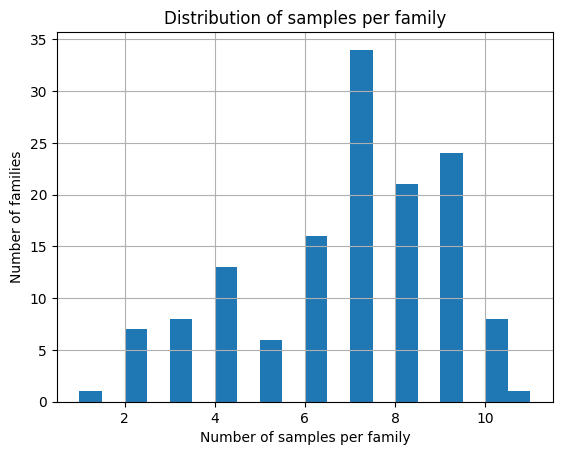

In [27]:
samples_per_family.hist(bins=20)
plt.xlabel("Number of samples per family")
plt.ylabel("Number of families")
plt.title("Distribution of samples per family")
plt.show()

In [28]:
#distribution of age groups
merged_samples["age_group_at_sample"].value_counts(dropna=False)

age_group_at_sample
NaN          122
8 weeks      105
4 months     103
5 months      96
9 months      92
6 months      88
1-2 weeks     84
11 months     83
4 weeks       82
14 months     75
Name: count, dtype: int64

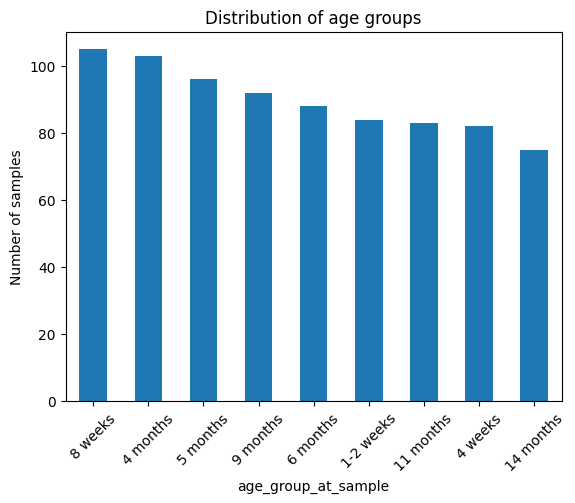

In [29]:
merged_samples["age_group_at_sample"].value_counts().plot(kind="bar")
plt.title("Distribution of age groups")
plt.ylabel("Number of samples")
plt.xticks(rotation=45)
plt.show()

In [30]:
#dimensionality and sparsity of the microbiome feature matrix
metadata_cols = [
    "sample_id",
    "family_id",
    "sex",
    "body_product",
    "age_group_at_sample",
    "year_of_birth",
]
feature_cols = [c for c in merged_samples.columns if c not in metadata_cols]

X = merged_samples[feature_cols]

print("Feature matrix shape:", X.shape)
print("Overall fraction of zeros:", (X == 0).mean().mean())

Feature matrix shape: (930, 6903)
Overall fraction of zeros: 0.9556136571445484


In [31]:
#number of observed taxa per sample
nonzero_per_sample = (X > 0).sum(axis=1)
nonzero_per_sample.describe()

count     930.000000
mean      306.398925
std       338.629879
min        46.000000
25%       127.000000
50%       181.000000
75%       282.000000
max      1821.000000
dtype: float64

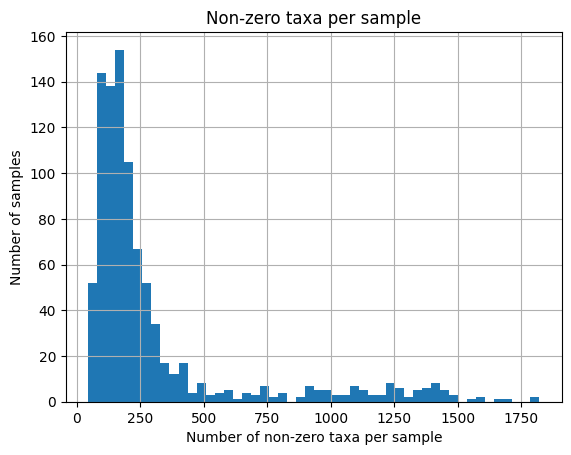

In [32]:
nonzero_per_sample.hist(bins=50)
plt.xlabel("Number of non-zero taxa per sample")
plt.ylabel("Number of samples")
plt.title("Non-zero taxa per sample")
plt.show()

In [33]:
# Total abundance per sample (sanity check)
total_abundance = X.sum(axis=1)
total_abundance.describe()

count    930.000000
mean     704.546050
std       64.838116
min      337.616534
25%      676.683539
50%      715.251764
75%      749.225950
max      800.000170
dtype: float64

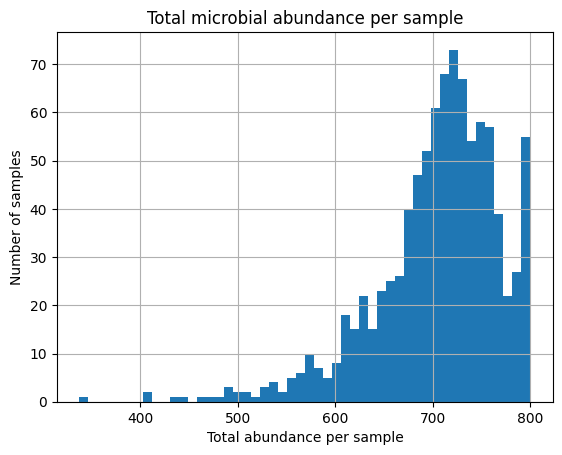

In [34]:
total_abundance.hist(bins=50)
plt.xlabel("Total abundance per sample")
plt.ylabel("Number of samples")
plt.title("Total microbial abundance per sample")
plt.show()

In [35]:
# Distribution of feature prevalence
feature_prevalence = (X > 0).sum(axis=0)
feature_prevalence.describe()

count    6903.000000
mean       41.279299
std        96.983595
min         1.000000
25%         2.000000
50%         9.000000
75%        38.000000
max       930.000000
dtype: float64

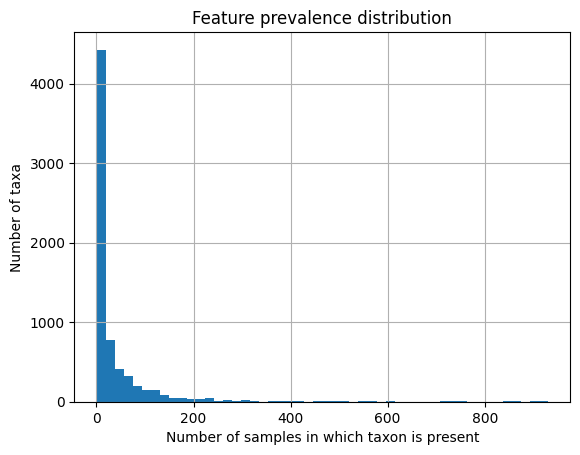

In [36]:
feature_prevalence.hist(bins=50)
plt.xlabel("Number of samples in which taxon is present")
plt.ylabel("Number of taxa")
plt.title("Feature prevalence distribution")
plt.show()

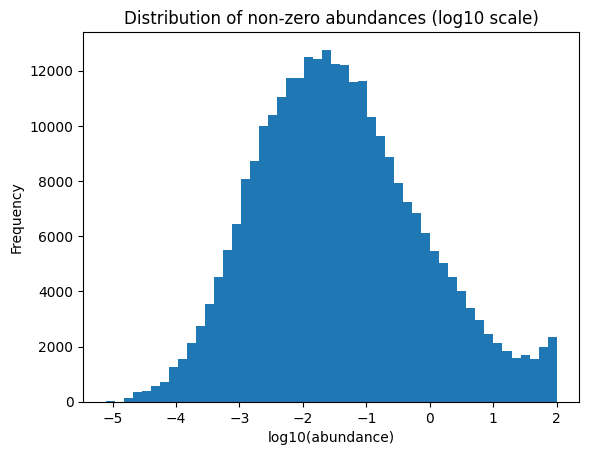

In [37]:
# Distribution of non-zero abundances (log scale)

nonzero_values = X.values[X.values > 0]
plt.hist(np.log10(nonzero_values), bins=50)
plt.xlabel("log10(abundance)")
plt.ylabel("Frequency")
plt.title("Distribution of non-zero abundances (log10 scale)")
plt.show()

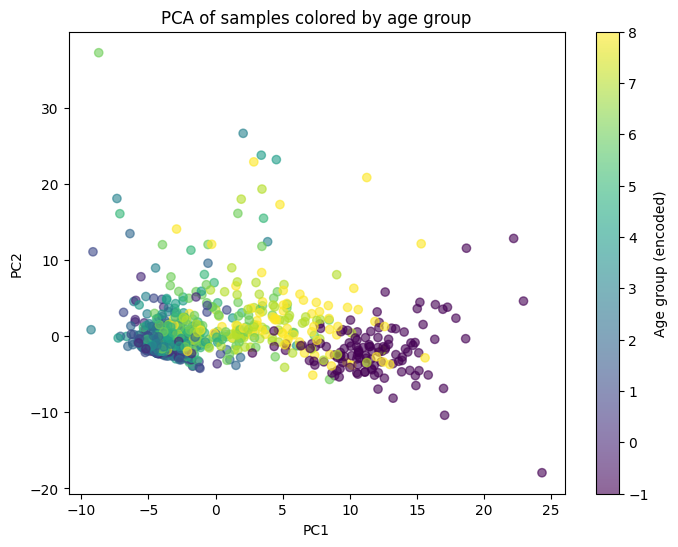

Explained variance ratio: [0.07129799 0.0296899 ]


In [38]:
# PCA visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Use a subset of features for speed
prevalence = (X > 0).sum(axis=0)
top_features = prevalence.sort_values(ascending=False).head(500).index

X_sub = X[top_features]

# Scale features
X_scaled = StandardScaler().fit_transform(X_sub)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
age = merged_samples["age_group_at_sample"]

plt.figure(figsize=(8,6))
plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1],
            c=pd.factorize(age)[0], cmap="viridis", alpha=0.6)
plt.colorbar(label="Age group (encoded)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of samples colored by age group")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

### Summary of EDA
The dataset consists of 930 stool samples derived from multiple individuals across different families and contains approximately 6,900 microbiome features, making it a high-dimensional and highly sparse dataset. Each sample contains on average around 300 detected taxa, while the total microbial abundance per sample is relatively stable, indicating that sequencing depth is consistent across samples.
Most taxa are rare and occur in only a small fraction of samples, whereas a small subset of taxa is highly prevalent across the cohort. The distribution of non-zero abundances follows an approximately log-normal shape, which is typical for microbiome sequencing data (e.g., Lutz et al., 2022).
A PCA projection based on the most prevalent taxa does not reveal sharply separated clusters but shows a gradual age-related gradient, suggesting that age-related variation in microbiome composition is present but represents only a limited fraction of the total variance in the data.

# Model Training

### Filtering for features at the genus level

In [39]:
def filter_genus(df_uf): #Defining a function that filters a dataframe to only include columns with features at genus level
    df_uf = df_uf.drop(list(df_uf.filter(regex="s__")),axis=1,inplace=False) #Drops columns that include features at species level
    df_uf = df_uf.filter(regex="g__") #Drops columns that include features broader than genus level
    return df_uf

In [40]:
X_train_genus = filter_genus(X_train)
X_test_genus = filter_genus(X_test)

### Random Forest Regressor with Train/Test split (Genus)

In [56]:
# create model
# Base model
rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

# Hyperparameter space
param_dist = {
    "n_estimators": [300, 500, 800, 1000],
    "max_depth": [None, 10, 20, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ["sqrt", "log2"]
}

# Randomized search with 5-fold CV on training set
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=25,
    cv=5,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit search
search.fit(X_train_genus, Y_train)

# Best model
best_model = search.best_estimator_
print("Best hyperparameters:", search.best_params_)

# CV RMSE of best model
best_cv_rmse = (-search.best_score_) ** 0.5
print("Best CV RMSE:", best_cv_rmse)

# evaluate model
yhat = model.predict(X_test_genus)
mse = mean_squared_error(Y_test, yhat)
print('Mean Squared Error: %.3f' % mse)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   1.4s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   1.4s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators

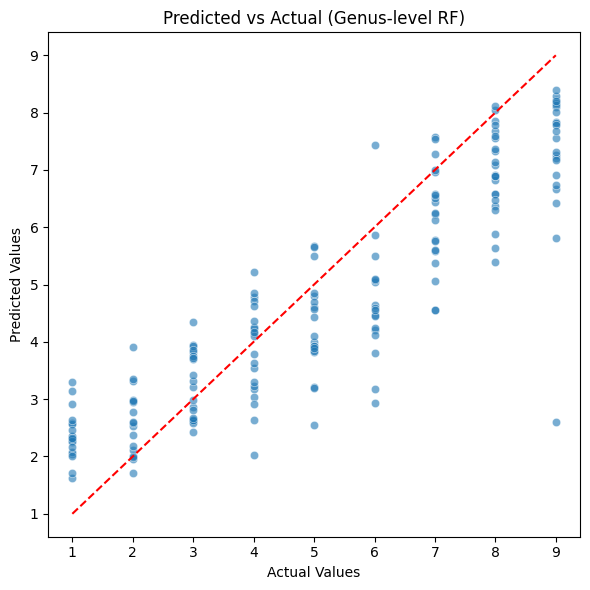

In [57]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_test, y=yhat, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Genus-level RF)")
plt.tight_layout()
plt.show()

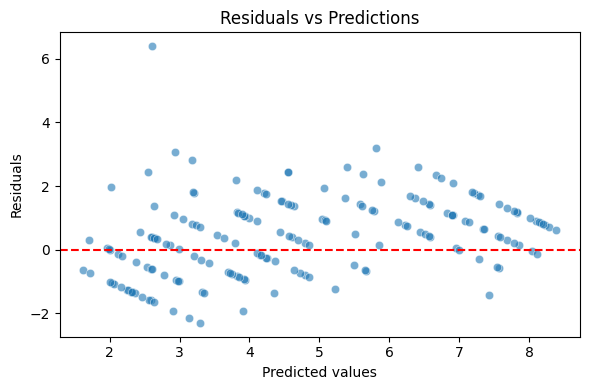

In [58]:
residuals = Y_test - yhat

plt.figure(figsize=(6,4))
sns.scatterplot(x=yhat, y=residuals, alpha=0.6)
plt.axhline(0, linestyle="--", color="red")

plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.tight_layout()
plt.show()

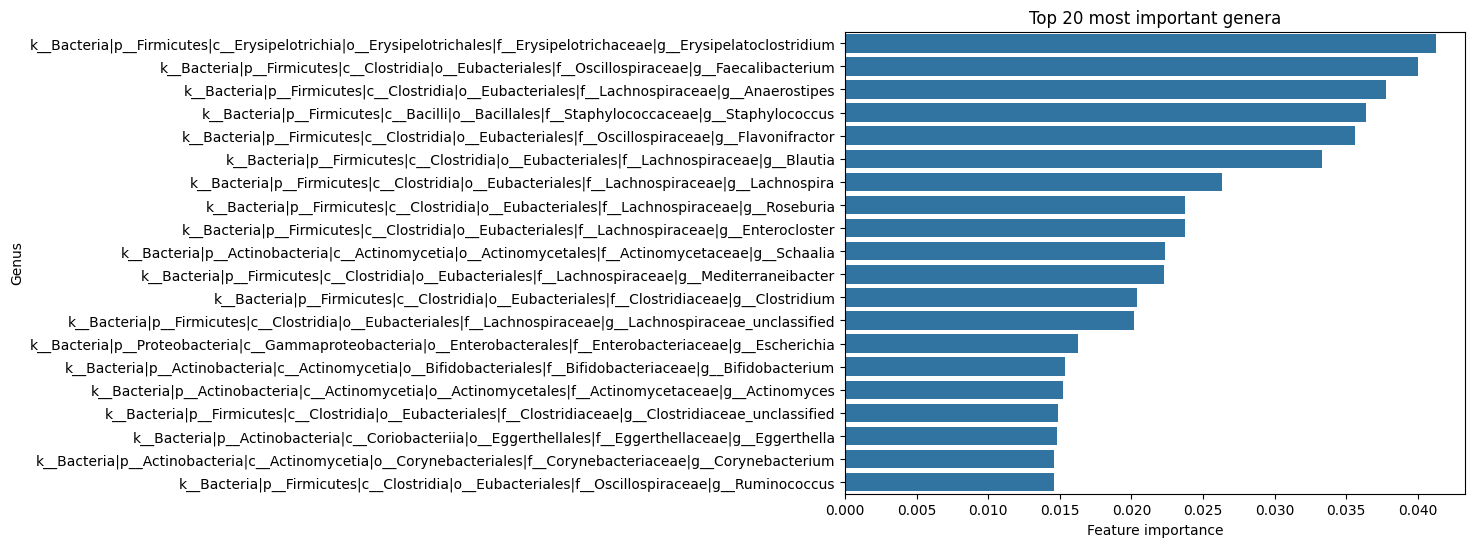

In [59]:
importances = pd.Series(
    model.feature_importances_,
    index=X_train_genus.columns
).sort_values(ascending=False)

top_n = 20

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances.head(top_n),
    y=importances.head(top_n).index
)

plt.xlabel("Feature importance")
plt.ylabel("Genus")
plt.title(f"Top {top_n} most important genera")
plt.tight_layout()
plt.show()